In [2]:
%pip install HanTa
%pip install lda
%pip install pyldavis
%pip install germalemma==0.1.3

Note: you may need to restart the kernel to use updated packages.
  Using cached lda-2.0.0.tar.gz (320 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for lda
Failed to build lda
  Running setup.py install for lda: started
  Running setup.py install for lda: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [53 lines of output]
      c:\Softwares\anaconda3\envs\dbse-project\lib\site-packages\setuptools\dist.py:770: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
        warnings.warn(
      c:\Softwares\anaconda3\envs\dbse-project\lib\site-packages\setuptools\dist.py:770: UserWarning: Usage of dash-separated 'author-email' will not be supported in future versions. Please use the underscore name 'author_email' instead
        warnings.warn(
      c:\Softwares\anaconda3\envs\dbse-project\lib\site-packages\setuptools\dist.py:770: UserWarning: Usage of dash-separated 'pre-hook.sdist_pre_hook' will not be supported in future versions. Please use the underscore name 'pre_hook.sdist_pre_hook' instead
        warnings.warn(
      c:\Softwares\anaconda3\envs\dbse-project\

  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.33
    Uninstalling Cython-0.29.33:
      Successfully uninstalled Cython-0.29.33
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
# import lda
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from HanTa import HanoverTagger as ht
from nltk.corpus import stopwords
from germalemma import GermaLemma
import pyLDAvis.gensim_models
import pyLDAvis
pyLDAvis.enable_notebook()

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
en_tagger = ht.HanoverTagger('morphmodel_en.pgz')
de_tagger = ht.HanoverTagger('morphmodel_ger.pgz')


[nltk_data] Downloading package wordnet to C:\Users\Er Pravin
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Er Pravin
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Er Pravin
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Er Pravin
[nltk_data]     Pandey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
def clean_data():
    def remove_emojis(data):
        emoj = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          u"\U00002500-\U00002BEF"  # chinese char
                          u"\U00002702-\U000027B0"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          u"\U0001f926-\U0001f937"
                          u"\U00010000-\U0010ffff"
                          u"\u2640-\u2642"
                          u"\u2600-\u2B55"
                          u"\u200d"
                          u"\u23cf"
                          u"\u23e9"
                          u"\u231a"
                          u"\ufe0f"  # dingbats
                          u"\u3030"
                          "]+", re.UNICODE)
        return re.sub(emoj, '', data)

    # Removing mentions and hashtags and url
    def remove_mentions_and_tags(text):
        text = re.sub(r'@\S*', '', text)
        text = re.sub(r'http\S+', '', text)
        return re.sub(r'#\S*', '', text)

    read_df = pd.read_parquet("twitter_data.parquet")
    read_df = read_df.drop_duplicates(subset=['tweet_id'])
    read_df = read_df.loc[read_df['tweet_type'] != 'retweet']
    read_df.text = read_df.text.apply(remove_emojis)
    read_df.text = read_df.text.apply(remove_mentions_and_tags)
    read_df['text'] = read_df['text'].str.replace(r'[^\w\s]+', '')  # remove punctuations
    read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number
    en_df = read_df[read_df.tweet_language == 'en']
    de_df = read_df[read_df.tweet_language == 'de']
    return en_df, de_df, read_df

def extract_adj_noun(df, tagger: ht.HanoverTagger, lang: str):

  def noun(text, tagger):
    words = nltk.word_tokenize(text)
    tokens = [word for (word, x, pos) in tagger.tag_sent(
        words, taglevel=1) if pos == 'NN']
    return tokens

  def adj(text, tagger):
    words = nltk.word_tokenize(text)
    tokens = [word for (word, x, pos) in tagger.tag_sent(
        words, taglevel=1) if pos == 'ADJ']
    return tokens

  def to_lowercase(text):
    token = []
    for i in range(len(text)):
      val = text[i].lower()
      token.append(val)
    return token

  def stop_word_removal(x, stop_words):
    return ' '.join([w for w in x if not w in stop_words])

  df['noun'] = df.text.apply(noun, tagger=tagger)
  df['adj'] = df.text.apply(adj, tagger=tagger)
  df.noun = df.noun.apply(to_lowercase)
  stop_words = stopwords.words(lang)
  stop_words.append('amp')
  df.noun = df.noun.apply(stop_word_removal, stop_words=stop_words)
  df.adj = df.adj.apply(stop_word_removal, stop_words=stop_words)
  return df


def lementize_en_text(df):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = nltk.stem.WordNetLemmatizer()

  def lemmatize_text(text):
    return [lemmatizer.lemmatize(w, 'n') for w in w_tokenizer.tokenize(text)]

  def lemmatize_text_adj(text):
    return [lemmatizer.lemmatize(w, 'a') for w in w_tokenizer.tokenize(text)]

  df['lemma_noun'] = df.noun.apply(lemmatize_text)
  df['lemma_adj'] = df.adj.apply(lemmatize_text_adj)
  dict_docs = df.lemma_noun.to_dict()
  return df, dict_docs


def lementize_de_text(df):
  lemmatizer = GermaLemma()

  def lemmatize_noun(x):
    arr = []
    token = x.split()
    for i in range(len(token)):
      lemma_noun = lemmatizer.find_lemma(token[i], 'N')
      arr.append(lemma_noun)
    return arr

  def lemmatize_adj(x):
    arr = []
    token = x.split()
    for i in range(len(token)):
      lemma_noun = lemmatizer.find_lemma(token[i], 'ADJ')
      arr.append(lemma_noun)
    return arr

  df['lemma_noun'] = df.noun.apply(lemmatize_noun)
  df['lemma_adj'] = df.adj.apply(lemmatize_adj)
  dict_docs = df.lemma_noun.to_dict()
  return df, dict_docs


def lda_topic_model(df):

  def generate_tokens(tweet):
    words = []
    for i in range(len(tweet)):
      word = tweet[i]
    # using the if condition because we introduced extra spaces during text cleaning
      if word != '':
        words.append(word)
    return words

  def create_dictionary(words):
    return corpora.Dictionary(words)

  def create_document_matrix(tokens, id2word):
    corpus = []
    for text in tokens:
      corpus.append(id2word.doc2bow(text))
    return corpus

  #storing the generated tokens in a new column named 'words'
  df['tokens'] = df.lemma_noun.apply(generate_tokens)

  #passing the dataframe column having tokens as the argument
  id2word = create_dictionary(df.tokens)

  #passing the dataframe column having tokens and dictionary
  corpus = create_document_matrix(df.tokens, id2word)
  return corpus, id2word


def fetch_doc_topic(df, corpus, lda_model, ntopics):
    def get_doc_topic(corpus, model):
        doc_topic = []
        for doc in range(len(corpus)):
            try:
                doc_topic.append(
                    {'Tweet': df.iloc[doc].text, 'Hashtags': df.iloc[doc].hashtags, 'Topic_Probability': model.__getitem__(corpus[doc], eps=0)})
            except Exception as e:
                print(e)
        return doc_topic

    def calc_doc_topic_count(doc_topic, count_arr):
        for topic in doc_topic:
            prob = topic['Topic_Probability']
            big = -99999
            for p in prob:
                if p[1] > big:
                    big = p[1]
                    max_top = p[0]
            count_arr[max_top] += 1
        return count_arr

    doc_topic = get_doc_topic(corpus, lda_model)
    doc_topic_df = pd.DataFrame(doc_topic)
    count_arr = calc_doc_topic_count(doc_topic, [0]*ntopics)
    return doc_topic, doc_topic_df, count_arr


def doc_topic_pie_chart(ntopics, count_arr):
    topics = []
    for i in range(ntopics):
        topics.append(i+1)
    plt.figure(figsize=(8, 8))
    plt.pie(count_arr, labels=topics,
            autopct='%1.1f%%', textprops={'fontsize': 18})
    plt.title('Tweets distribution in topics', fontsize=20)
    #plt.legend(data_pie.tweets_count,fontsize=20)
    plt.show()


def print_beauty(df, word_topic_df):
    for i in range(6, 10):
        print('Tweet:', df.iloc[i].Tweet)
        print('Hashtags:', df.iloc[i].Hashtags)
        print('Topic_Probability:', df.iloc[i].Topic_Probability)
        print("----------------------------------------------------------------\n")

    for i in range(4):
        print("Topic ", (i+1))
        print("Most Probable Word List: ",
              word_topic_df.iloc[i].most_prob_words)
        print("-------------------------------------------------------\n")


def fetch_word_topic(lda_model, id2word):
    def get_topic_to_wordids(model):
        p = list()
        for topicid in range(model.num_topics):
            topic = model.state.get_lambda()[topicid]
            topic = topic / max(topic)  # normalize to probability dist
            p.append(topic)
        return p

    def create_dict_word_topic(id2word, word_topic):
        word_topic_dict = []
        i = 0
        for topic in word_topic:
            prob_words = []
            for word_ind in range(len(topic)):
                if (topic[word_ind] >= 0.15):
                    prob_words.append(id2word[word_ind])
            word_topic_dict.append(
                {'Topic': (i+1), 'most_prob_words': prob_words})
            i += 1
        return word_topic_dict

    word_topic = get_topic_to_wordids(lda_model)
    word_topic_dict = create_dict_word_topic(id2word, word_topic)
    word_topic_df = pd.DataFrame(word_topic_dict)
    return word_topic_dict, word_topic_df


<>:37: DeprecationWarning: invalid escape sequence \d
<>:37: DeprecationWarning: invalid escape sequence \d
C:\Users\Er Pravin Pandey\AppData\Local\Temp\ipykernel_12908\763361653.py:37: DeprecationWarning: invalid escape sequence \d
  read_df['text'] = read_df['text'].str.replace('\d+', '')  # removes number


In [5]:
en_topics = 4
de_topics = 5

def run(df, tagger: ht.HanoverTagger, language: str, n_topics: int):
    df = extract_adj_noun(en_df, tagger, language)
    if language == "english":
        df, dict_docs = lementize_en_text(df)
    else:
        df, dict_docs = lementize_de_text(df)
    corpus, id2word = lda_topic_model(df)
    lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus, id2word=id2word, num_topics=n_topics, random_state=42)
    doc_topic, doc_topic_df, count_arr = fetch_doc_topic(
        df, corpus, lda_model, n_topics)
    word_topic_dict, word_topic_df = fetch_word_topic(lda_model, id2word)
    return df, dict_docs, corpus, id2word, lda_model, doc_topic, doc_topic_df, count_arr, word_topic_dict, word_topic_df


en_df, de_df, read_df = clean_data()

In [6]:
en_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel in German The debate...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,Thread summarizing a video by the German Fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,On job in German and its impact on life and...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,German researchers without a permanent post i...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en


In [7]:
de_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language
1,2021-06-20T21:29:24.000Z,1406725899744157698,1406725899744157698,2981738470,Wenn Wirtschaftsjounalistinnen über schreiben...,9,1,62,4,[],['IchbinHanna'],original,de
16,2021-06-18T10:21:31.000Z,1405833045224087555,1405833045224087555,242424959,Liebe und Forsa schön dass ihr euch per Umfr...,0,1,2,0,[],"['Mittelbau', 'IchBinHanna']",original,de
19,2021-06-18T08:35:29.000Z,1405806358335832065,1405806358335832065,1132055796571877376,Wichtiger Thread zu in der der durch die A...,2,0,13,0,"[{'type': 'quoted', 'id': '1405494574533984264'}]","['Machtmissbrauch', 'Wissenschaft', 'prekär', ...",original,de
21,2021-06-18T07:52:36.000Z,1405795569273131011,1405795569273131011,1132055796571877376,Wir können ja mal einen für machen Wer macht...,4,0,16,0,"[{'type': 'quoted', 'id': '1405617868734148610'}]","['FollowFriday', 'IchbinHanna', 'WissZeitVG', ...",original,de
22,2021-06-18T02:42:56.000Z,1405717636999155717,1405717636999155717,2981738470,Das ist übrigens ein Punkt der mir bei einfac...,1,0,6,0,"[{'type': 'quoted', 'id': '1405460325437149186'}]",['IchbinHanna'],original,de


In [8]:
en_df, en_dict_docs, en_corpus, en_id2word, en_lda_model, en_doc_topic, en_doc_topic_df, en_count_arr, en_word_topic_dict, en_word_topic_df = run(
    en_df, en_tagger, "english", en_topics)

de_df, de_dict_docs, de_corpus, de_id2word, de_lda_model, de_doc_topic, de_doc_topic_df, de_count_arr, de_word_topic_dict, de_word_topic_df = run(
    de_df, de_tagger, "german", de_topics)

In [9]:
en_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language,noun,adj,lemma_noun,lemma_adj,tokens
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel in German The debate...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en,,,[],[],[]
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,Thread summarizing a video by the German Fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en,indignation,,[Indignation],[],[Indignation]
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,On job in German and its impact on life and...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en,,,[],[],[]
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en,,,[],[],[]
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,German researchers without a permanent post i...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en,post situation,,"[Post, Situation]",[],"[Post, Situation]"


In [10]:
de_df.head()

,timestamp,tweet_id,conversation_id,author_id,text,retweet_count,reply_count,like_count,quote_count,referenced_tweets,hashtags,tweet_type,tweet_language,noun,adj,lemma_noun,lemma_adj,tokens
11,2021-06-18T13:10:36.000Z,1405875593711964166,1405875593711964166,1132055796571877376,Thread about the cruel in German The debate...,5,0,19,0,"[{'type': 'quoted', 'id': '1405846267759054851'}]","['precarity', 'academia', 'IchbinHanna', 'Acad...",original,en,,,[],[],[]
105,2021-06-12T21:15:23.000Z,1403823267115376649,1403823267115376649,1132055796571877376,Thread summarizing a video by the German Fede...,1,0,9,1,"[{'type': 'quoted', 'id': '1403006909079293953'}]","['IchbinHanna', 'academia', 'Germany', 'toxica...",original,en,indignation,,[Indignation],[],[Indignation]
125,2021-06-11T22:32:52.000Z,1403480380632674307,1403480380632674307,1132055796571877376,On job in German and its impact on life and...,0,0,1,0,"[{'type': 'quoted', 'id': '1402963684691955714'}]","['precarity', 'academia', 'family', 'mentalhea...",original,en,,,[],[],[]
215,2021-06-10T19:07:52.000Z,1403066401611472902,1403066401611472902,1132055796571877376,,0,0,1,0,"[{'type': 'quoted', 'id': '1403059508021284864'}]","['AcademicTwitter', 'acertaindegreeofflexibili...",original,en,,,[],[],[]
238,2021-06-10T15:04:44.000Z,1403005214974640143,1403005214974640143,1132055796571877376,German researchers without a permanent post i...,7,0,15,0,"[{'type': 'quoted', 'id': '1402994337009442820'}]","['IchbinHanna', 'academia', 'AcademicTwitter',...",original,en,post situation,,"[Post, Situation]",[],"[Post, Situation]"


In [11]:
def create_doc_count_vector(df):
    vect = CountVectorizer()
    vects = vect.fit_transform(df.noun)
    newdf = pd.DataFrame(vects.todense())
    newdf.columns = vect.get_feature_names()
    tdm = newdf.T
    tdm.columns = ['Doc '+str(i) for i in range(newdf.shape[0])]
    tdm['total_count'] = tdm.sum(axis=1)
    tdm = tdm.sort_values(by='total_count', ascending=False)
    tdm = tdm.drop(columns=['total_count'], axis=1)
    dtm = tdm.to_numpy()
    return tdm, dtm

# en_tdm, en_dtm = create_doc_count_vector(en_df)
# de_tdm, de_dtm = create_doc_count_vector(de_df)

In [12]:
def lda_topic_model_search(dtm, n_topics):
    log_likelihoods = []
    lda_models = []

    for i in n_topics:
        tdm_lda = lda.LDA(n_topics=i, n_iter=1000, random_state=42)
        tdm_lda.fit(dtm)
        log_likelihoods.append(tdm_lda.loglikelihoods_[99])
        lda_models.append(tdm_lda)
    return log_likelihoods, lda_models

def create_plot(n_topics, log_like):
    plt.plot(n_topics, log_like)
    plt.xticks(np.arange(min(n_topics), max(n_topics)+1, 2))
    plt.gca().invert_yaxis()
    plt.title('Selection of Number of Topics')
    plt.xlabel(' Number of Topics')
    plt.ylabel(' Log Likelihoods')
    plt.show()

n_topics = []
for i in range(2, 41):
    n_topics.append(i)

# en_log_like, en_lda = lda_topic_model_search(dtm=en_dtm, n_topics=n_topics)
# de_log_like, de_lda = lda_topic_model_search(dtm=de_dtm, n_topics=n_topics)

# create_plot(n_topics, en_log_like)

In [13]:
# create_plot(n_topics, de_log_like)

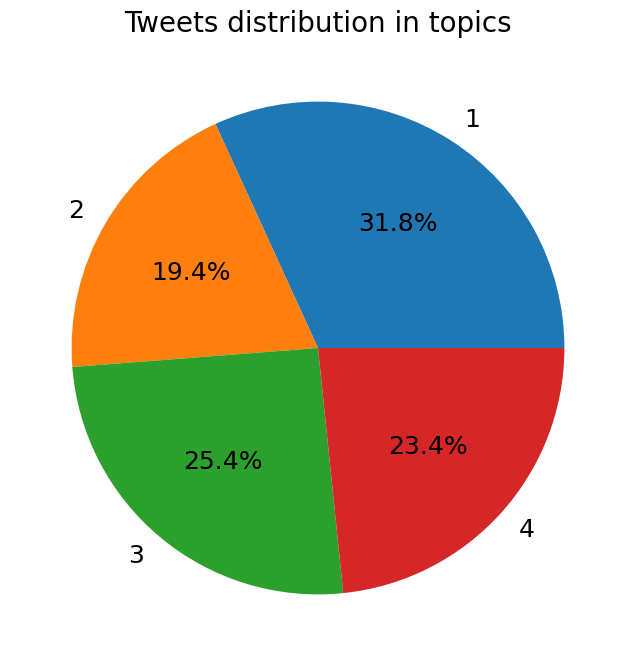

In [14]:
doc_topic_pie_chart(en_topics, en_count_arr)

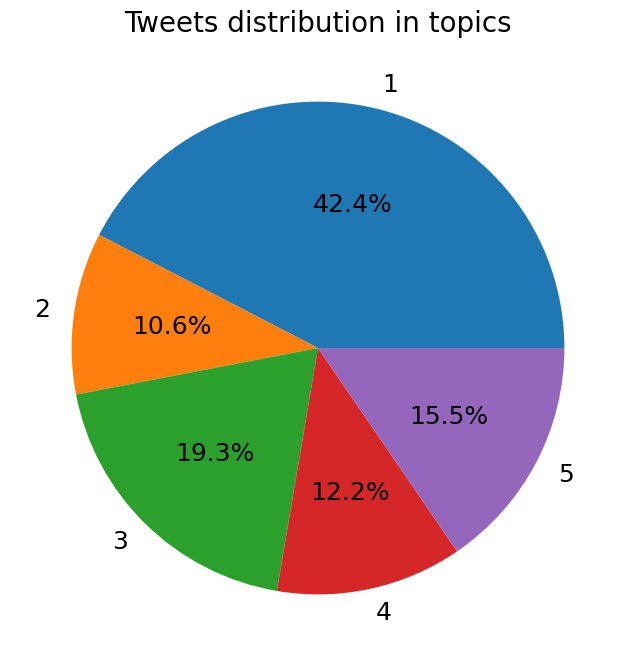

In [15]:
doc_topic_pie_chart(de_topics, de_count_arr)

In [16]:
print_beauty(en_doc_topic_df, en_word_topic_df)


Tweet: Like so many  Ive learned that I am a good enough researcher to stay in academia but what the  does is not to select the best candidates It also does not train researchers to become the best candidates deserving of permanent jobs
Hashtags: ['IchbinHanna', 'WissZeitVG']
Topic_Probability: [(0, 0.37078837), (1, 0.45266563), (2, 0.08668429), (3, 0.08986175)]
----------------------------------------------------------------

Tweet: For those who dont read German

The response by the ministry of education to the outpouring of stories and discussions regarding academic precarity  is unbelievably patronising and disrespectful
Hashtags: ['IchBinHanna']
Topic_Probability: [(0, 0.04320894), (1, 0.044390544), (2, 0.043253437), (3, 0.86914706)]
----------------------------------------------------------------

Tweet: So  proudly explains the advantages of the  to early carrer researchers as if they were preschool children This law is a great obstacle to many brilliant young minds and threaten

In [17]:
print_beauty(de_doc_topic_df, de_word_topic_df)


Tweet: Like so many  Ive learned that I am a good enough researcher to stay in academia but what the  does is not to select the best candidates It also does not train researchers to become the best candidates deserving of permanent jobs
Hashtags: ['IchbinHanna', 'WissZeitVG']
Topic_Probability: [(0, 0.050005935), (1, 0.05009091), (2, 0.7998286), (3, 0.05003201), (4, 0.050042592)]
----------------------------------------------------------------

Tweet: For those who dont read German

The response by the ministry of education to the outpouring of stories and discussions regarding academic precarity  is unbelievably patronising and disrespectful
Hashtags: ['IchBinHanna']
Topic_Probability: [(0, 0.2), (1, 0.2), (2, 0.2), (3, 0.2), (4, 0.2)]
----------------------------------------------------------------

Tweet: So  proudly explains the advantages of the  to early carrer researchers as if they were preschool children This law is a great obstacle to many brilliant young minds and threatens 

In [18]:
vis = pyLDAvis.gensim_models.prepare(en_lda_model,
                                     en_corpus,
                                     dictionary=en_lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.049501 -0.104257       1        1  28.332599
3      0.015974 -0.104992       2        1  27.016616
0     -0.189638  0.061004       3        1  23.322397
1      0.124163  0.148245       4        1  21.328389, topic_info=           Term        Freq       Total Category  logprob  loglift
347        link  310.000000  310.000000  Default  30.0000  30.0000
955       click  193.000000  193.000000  Default  29.0000  29.0000
953       music  174.000000  174.000000  Default  28.0000  28.0000
1        thread  287.000000  287.000000  Default  27.0000  27.0000
14    situation  185.000000  185.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
256         day   35.806607  103.747120   Topic4  -5.0065   0.4813
31       system   38.594664  346.167415   Topic4  -4.9315  -0.6487
878     service   29.193413   48.075364   Topic4  -5.2107   1.0463
103     student   31.916146  109.286294   Topic4  -5.1215   0.3143
144  university   29.692673  188.086716   Topic4  -5.1938  -0.3009

[267 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
20        1  0.257648  academia
20        2  0.235168  academia
20        3  0.390794  academia
20        4  0.115855  academia
390       2  0.036057    advice
...     ...       ...       ...
35        4  0.670727      year
318       1  0.102661     youre
318       2  0.136882     youre
318       3  0.136882     youre
318       4  0.615968     youre

[500 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

In [19]:
vis = pyLDAvis.gensim_models.prepare(de_lda_model,
                                     de_corpus,
                                     dictionary=de_lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.163834  0.078028       1        1  27.159245
4      0.163098 -0.039545       2        1  21.334123
3     -0.061183 -0.255982       3        1  19.497433
1     -0.030989  0.142632       4        1  16.799820
0     -0.234759  0.074867       5        1  15.209379, topic_info=         Term        Freq       Total Category  logprob  loglift
6         Not  694.000000  694.000000  Default  30.0000  30.0000
36       Here  320.000000  320.000000  Default  29.0000  29.0000
51      These  218.000000  218.000000  Default  28.0000  28.0000
31        See  133.000000  133.000000  Default  27.0000  27.0000
2   Situation  153.000000  153.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
50       Kind    7.217247   20.501170   Topic5  -5.2023   0.8392
73       Look    9.763053   94.001928   Topic5  -4.9002  -0.3815
65       Most    9.801535  107.368914   Topic5  -4.8963  -0.5105
55   Position    9.278916  162.960487   Topic5  -4.9511  -0.9825
67      Start    6.617648   52.915823   Topic5  -5.2891  -0.1957

[245 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
23        2  0.862090   Account
23        4  0.057473   Account
23        5  0.114945   Account
757       4  0.121779    Agenda
757       5  0.730676    Agenda
...     ...       ...       ...
263       4  0.702334  Workshop
320       4  0.867207     Would
358       2  0.956787   Youtube
180       1  0.914641         a
72        5  0.826203         b

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 2, 1])

Topic Modelling using - BERT

In [26]:
#german
from bertopic import BERTopic

de_model = BERTopic(verbose=True, language="German")
de_docs = de_df.text.to_list()

de_topics, de_probabilities = de_model.fit_transform(de_docs)

Batches: 100%|██████████| 192/192 [01:07<00:00,  2.86it/s]
2023-03-03 20:48:50,372 - BERTopic - Transformed documents to Embeddings
2023-03-03 20:49:00,934 - BERTopic - Reduced dimensionality
2023-03-03 20:49:01,196 - BERTopic - Clustered reduced embeddings


In [27]:
de_model.get_topic_freq().head(11)

,Topic,Count
0,-1,2292
1,0,1555
2,1,231
3,2,140
4,3,140
5,4,112
6,5,88
7,6,82
8,7,74
9,8,71


In [28]:
de_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'german | germany | in | the | of', 1555],
                                   [1, 'counting | community | stop | from | amp', 231],
                                   [2, 'white | gender | women | of | scholars', 140],
                                   [3, 'science | scientists | young | researchers | we', 140],
                                   [4, 'und | oh | nailed | yes | es', 112],
                                   [5, 'contract | contracts | months | my | fixedterm', 88],
                                   [6, 'years | permanent | the | but | contracts', 82],
                                   [7, 'strike | pay | union | uk | join', 74],
                                   [8, 'academia | poor | as | you | is', 71],
                                   [9, 'this | exactly | lifeonhold | pan | refer', 62],
                                   [10, 'academia | leaving | leave | my | im', 60],
                                   [11, 'authors | book | reviewers | publish | publishers', 57],
                                   [12, 'work | job | multiple | working | more', 51],
                                   [13, 'panel | conference | meeting | discussion | event', 49],
                                   [14, 'intersectional | discussion | intersectionality | debate | not',
                                    47],
                                   [15, 'postdoc | postdocs | tenure | years | track', 46],
                                   [16, 'power | abuse | bullying | academic | change', 45],
                                   [17, 'conditions | working | academia | labor | our', 40],
                                   [18, 'thread | hervorragender | ltsomethinggt | gone | wrong', 39],
                                   [19, 'phd | phds | are | students | doing', 38],
                                   [20, 'airdrop | telegram | bot | retweet | follow', 38],
                                   [21, 'movement | change | is | if | the', 37],
                                   [22, 'power | individuals | privilege | those | their', 35],
                                   [23, 'weekend | week | break | holidays | day', 33],
                                   [24, 'precarity | academic | zu | report | oecd', 29],
                                   [25, 'weekends | vacation | work | time | not', 28],
                                   [26, 'music | kindly | click | link | below', 27],
                                   [27, 'hanna | herhisthey | hannas | probably | elternzeit', 26],
                                   [28, 'funding | grants | grant | submitted | project', 25],
                                   [29, 'researchers | research | situations | increased | contracts', 23],
                                   [30, 'international | gt | problem | world | an', 23],
                                   [31, 'mobility | disabled | disability | virtual | academics', 23],
                                   [32, 'emma | her | phd | she | shares', 22],
                                   [33, 'letter | handover | signatories | signatures | cuts', 21],
                                   [34, 'system | broken | tik | tok | fck', 21],
                                   [35, 'thread | excellent | thank | this | read', 20],
                                   [36, 'hell | fresh | absoluter | wahnsinn | holy', 19],
                                   [37, 'anonymously | story | comfortable | ruffled | feathers', 19],
                                   [38, 'theology | professorship | religious | religion | ger', 18],
                                   [39, 'english | englishspeaking | version | website | article', 18],
                                   [40, 'nicht | bin | das | ich | als', 18],
                                   [41, 'unroll | compile | please | rdrop | ai', 18],
                                   [42, 'postdocs | phds | science | research | are', 17],
                       

In [29]:
de_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.011812448408641055, 0.013721721279444989,
                    0.017398853013341306, 0.021104935117139144,
                    0.023901137612209536],
              'xaxis': 'x',
              'y': [of  , the  , in  , germany  , german  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.2661533349405432, 0.33514029283749375, 0.7120609402258684,
                    0.7672276615806547, 1.2316498729505616],
              'xaxis': 'x2',
              'y': [amp  , from  , stop  , community  , counting  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.014588608136622914, 0.01606451468025769,
                    0.023664774396734846, 0.02531862385906901,
                    0.033967691327933015],
              'xaxis': 'x3',
              'y': [scholars  , of  , women  , gender  , white  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.015201449311405676, 0.015924582289684994,
                    0.022589526110474913, 0.028294713331119003,
                    0.03775008284712572],
              'xaxis': 'x4',
              'y': [we  , researchers  , young  , scientists  , science  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027843208483737926, 0.03516592875735646,
                    0.03617483679069115, 0.03872476858943802, 0.042472186824159854],
              'xaxis': 'x5',
              'y': [es  , yes  , nailed  , oh  , und  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.016279055538990124, 0.019902044742894292,
                    0.021215067363289757, 0.04460665375459651,
                    0.052065276734447746],
              'xaxis': 'x6',
              'y': [fixedterm  , my  , months  , contracts  , contract  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.013211322557973373, 0.013971725664865839,
                    0.015100390665019453, 0.017318057492855195,
                    0.019868278467421445],
              'xaxis': 'x7',
              'y': [contracts  , but  , the  , permanent  , years  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.026452149697830944, 0.030458123115990155,
                    0.03090353728833095, 0.031503807304632696, 0.0961399071691932],
              'xaxis': 'x8',
              'y': [join  , uk  , union  , pay  , strike  ],
              'yaxis': 'y8'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
               

In [30]:
#topic reduction
de_model = BERTopic(verbose=True, language="German",nr_topics=6) 
de_docs = de_df.text.to_list()

de_topics, de_probabilities = de_model.fit_transform(de_docs)

de_model.visualize_barchart()

Batches: 100%|██████████| 192/192 [01:05<00:00,  2.93it/s]
2023-03-03 20:51:36,461 - BERTopic - Transformed documents to Embeddings
2023-03-03 20:51:46,200 - BERTopic - Reduced dimensionality
2023-03-03 20:51:46,421 - BERTopic - Clustered reduced embeddings
2023-03-03 20:51:47,983 - BERTopic - Reduced number of topics from 54 to 6


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04651571988400256, 0.050873677940698796,
                    0.05606671536262385, 0.056655372663454634, 0.06896537290584764],
              'xaxis': 'x',
              'y': [and  , of  , to  , in  , the  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.058115078949719734, 0.06149172228054355,
                    0.06910643028018558, 0.08078644221225711, 0.13670772219142424],
              'xaxis': 'x2',
              'y': [we  , and  , the  , uk  , strike  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.0867446526066196, 0.0867446526066196, 0.09537526932418512,
                    0.10431089848198383, 1.2354204589205227],
              'xaxis': 'x3',
              'y': [hervorragender  , ltsomethinggt  , important  , this  , thread
                    ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.04896996171489232, 0.053658606490209954,
                    0.07290647590953804, 0.07345494257233848, 0.12402332004358552],
              'xaxis': 'x4',
              'y': [disability  , to  , the  , disabled  , mobility  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.10431069326799952, 0.10616731207297533, 0.11708370524526791,
                    0.15156588798179937, 0.22784999601426292],
              'xaxis': 'x5',
              'y': [religion  , the  , systematic  , professorship  , theology  ],
              'yaxis': 'y5'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 2',
                                'x': 0.6375000000000001,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 3',
                                'x': 0.9125,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 4',
                                'x': 0.0875,
                           

In [31]:
#english

en_model = BERTopic(verbose=True, language="English")
en_docs = en_df.text.to_list()

en_topics, en_probabilities = en_model.fit_transform(en_docs)

Batches: 100%|██████████| 192/192 [00:33<00:00,  5.81it/s]
2023-03-03 20:52:39,185 - BERTopic - Transformed documents to Embeddings
2023-03-03 20:52:49,846 - BERTopic - Reduced dimensionality
2023-03-03 20:52:50,079 - BERTopic - Clustered reduced embeddings


In [32]:
en_model.get_topic_freq().head(11)

,Topic,Count
0,-1,2421
1,0,272
2,1,239
3,2,234
4,3,137
5,4,134
6,5,118
7,6,117
8,7,112
9,8,110


In [33]:
en_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'amp | to | the | for | event', 272],
                                   [1, 'german | academia | system | germany | is', 239],
                                   [2, 'घटन | cool | running | guess | impact', 234],
                                   ...,
                                   [84, 'airdrop | telegram | june | reward | troy', 11],
                                   [85, 'museums | claiming | decolonize | museum | collections', 10],
                                   [86, 'contracts | seminar | contract | about | researchers', 10]],
                                  dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': array([272, 239, 234, 137, 134, 118, 117, 112, 110,  87,  84,  82,  80,  75,
                                         68,  58,  57,  52,  52,  49,  45,  44,  38,  37,  37,  35,  34,  34,
                                         33,  33,  32,  32,  32,  32,  32,  32,  30,  30,  30,  29,  28,  28,
                                         28,  27,  27,  27,  25,  24,  22,  20,  20,  20,  19,  19,  19,  19,
                                         19,  18,  18,  17,  17,  16,  16,  15,  15,  15,  15,  15,  15,  14,
                                         14,  14,  14,  14,  14,  14,  13,  13,  13,  12,  12,  12,  12,  11,
                                         11,  10,  10], dtype=int64),
                         'sizemode': 'area',
                         'sizeref': 0.17,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': array([-2.4827814 , -2.341416  ,  5.9711823 , -2.95502   , -3.0075343 ,
                          -2.8005621 ,  0.7899259 , -2.8290086 , -2.3562617 ,  5.437975  ,
                           1.3645093 ,  5.8742766 , -2.9063354 , 14.527779  ,  3.4838545 ,
                          14.404047  ,  5.3071437 , 15.061454  , 13.93164   ,  5.7729917 ,
                          -2.2968278 ,  3.6594224 ,  3.363576  ,  3.76835   , 11.280465  ,
                           5.9810886 ,  1.372714  ,  0.77428645, -1.8838692 ,  4.2125063 ,
                           5.1422663 ,  6.125173  ,  3.4038885 , -2.2570062 ,  6.680631  ,
                          -2.1510682 , 10.695261  , -2.2235649 , -2.7034318 , -1.9537405 ,
                           3.6554086 ,  5.248247  , 14.256331  , 13.931637  , 15.163153  ,
                          -2.0029066 ,  0.8279865 ,  5.7559066 ,  1.7311318 ,  4.365754  ,
                           3.8209834 , -2.0972416 ,  3.7247052 , 22.863998  ,  4.3402514 ,
                           6.163928  ,  5.1554627 , 14.273184  ,  3.6920633 , 13.78972   ,
                           4.4754453 , 10.988749  ,  1.4956818 , 22.86401   , 15.216247  ,
                           4.7501445 ,  0.90813863, -2.1445243 , -4.870819  ,  1.9439785 ,
                          11.138295  ,  4.3167005 ,  1.8535857 ,  6.2783446 , -4.834634  ,
                          -1.7042279 , 10.696336  ,  6.678158  , 13.889648  , 10.9675    ,
                          -4.936589  ,  3.356861  , 11.187072  ,  6.6798277 ,  4.8758082 ,
                           4.6568146 , 14.033404  ], dtype=float32),
              'xaxis': 'x',
              'y': array([  7.275537  ,   7.1654434 ,   7.6651926 ,   7.313681  ,   7.2473598 ,
                            8.157425  ,   3.2177565 ,   7.511505  ,   1.5274898 ,   9.135366  ,
                            2.5610323 ,   7.459334  ,   7.5153103 ,  -0.8471023 ,  -0.7035997 ,
                           -0.7074422 ,   9.11193   ,  -2.6818569 ,  15.727947  ,   7.3857565 ,
                            8.526045  , -

In [34]:
en_model.visualize_barchart()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.009410321184489092, 0.009488757947102897,
                    0.010031924890516452, 0.010377881470619632,
                    0.05237218483056185],
              'xaxis': 'x',
              'y': [event  , for  , the  , to  , amp  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.012218214966900646, 0.013883743629096404,
                    0.014301248632354092, 0.015621425027917411,
                    0.033280733785120406],
              'xaxis': 'x2',
              'y': [is  , germany  , system  , academia  , german  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.4363078735625224, 0.4495418807422089, 0.4730662840328561,
                    0.5634019998553296, 0.8291987952680497],
              'xaxis': 'x3',
              'y': [impact  , guess  , running  , cool  , घटन  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.010812373996099753, 0.011281357287976095,
                    0.011760826200719126, 0.0425316211795815, 0.047420178727358056],
              'xaxis': 'x4',
              'y': [to  , they  , for  , postdoc  , postdocs  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.013865441501287228, 0.014134274508374775,
                    0.02111385788971669, 0.021907431895562043,
                    0.026907564699286863],
              'xaxis': 'x5',
              'y': [we  , funding  , research  , science  , scientists  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.014889382664492856, 0.01713583815735008,
                    0.018946779891328914, 0.019745525575387453,
                    0.03128653282476313],
              'xaxis': 'x6',
              'y': [in  , my  , phd  , left  , germany  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.014760568924874541, 0.015200531452904727,
                    0.015446830274173248, 0.016859383824433666,
                    0.018068977405347162],
              'xaxis': 'x7',
              'y': [weekends  , holidays  , vacation  , work  , you  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.013663532004602123, 0.014587345177111532,
                    0.024229135337911448, 0.02429520704043377,
                    0.034047118424116056],
              'xaxis': 'x8',
              'y': [you  , my  , contracts  , years  , contract  ],
              'yaxis': 'y8'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.

In [35]:
#topic reduction
en_model = BERTopic(verbose=True, language="German",nr_topics=20) 
en_docs = en_df.text.to_list()

en_topics, en_probabilities = en_model.fit_transform(en_docs)

en_model.visualize_barchart()

Batches: 100%|██████████| 192/192 [01:04<00:00,  2.99it/s]
2023-03-03 20:55:08,456 - BERTopic - Transformed documents to Embeddings
2023-03-03 20:55:17,728 - BERTopic - Reduced dimensionality
2023-03-03 20:55:17,913 - BERTopic - Clustered reduced embeddings
2023-03-03 20:55:19,790 - BERTopic - Reduced number of topics from 63 to 20


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.0276193895167858, 0.028113480991580633, 0.03230152409596823,
                    0.03523384917969787, 0.035757653858761416],
              'xaxis': 'x',
              'y': [germany  , to  , german  , the  , in  ],
              'yaxis': 'y'},
             {'marker': {'color': '#0072B2'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.02853064463104811, 0.030480963686992043,
                    0.03223700431495424, 0.0337725969023941, 0.03382185498563138],
              'xaxis': 'x2',
              'y': [is  , hanna  , to  , this  , the  ],
              'yaxis': 'y2'},
             {'marker': {'color': '#CC79A7'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.027552719136030676, 0.027740133036417834,
                    0.029321815877869885, 0.030993213406238253,
                    0.031369756584913346],
              'xaxis': 'x3',
              'y': [is  , of  , to  , and  , the  ],
              'yaxis': 'y3'},
             {'marker': {'color': '#E69F00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.0373093548605531, 0.04008603001777163, 0.04151071073374578,
                    0.042278425257739616, 0.07346706641997039],
              'xaxis': 'x4',
              'y': [by  , future  , intersectionality  , discussion  ,
                    intersectional  ],
              'yaxis': 'y4'},
             {'marker': {'color': '#56B4E9'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.034642433093848596, 0.03504773422180756,
                    0.03603662099093717, 0.037159652036750423, 0.05154139181790338],
              'xaxis': 'x5',
              'y': [the  , and  , of  , to  , power  ],
              'yaxis': 'y5'},
             {'marker': {'color': '#009E73'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.030304051888938754, 0.0314055090344762, 0.03243114707140424,
                    0.033832834206216224, 0.06294016390899373],
              'xaxis': 'x6',
              'y': [that  , to  , authors  , the  , book  ],
              'yaxis': 'y6'},
             {'marker': {'color': '#F0E442'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03774110553040003, 0.03805943218009903, 0.04490602153957879,
                    0.049296243793054785, 0.05088909467958302],
              'xaxis': 'x7',
              'y': [follow  , our  , hashtag  , airdrop  , twitter  ],
              'yaxis': 'y7'},
             {'marker': {'color': '#D55E00'},
              'orientation': 'h',
              'type': 'bar',
              'x': [0.03986054221140895, 0.04138888387433763, 0.0433035832021073,
                    0.04442014544033399, 0.130914380188618],
              'xaxis': 'x8',
              'y': [on  , we  , uk  , pay  , strike  ],
              'yaxis': 'y8'}],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 0',
                                'x': 0.0875,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Topic 1',
                                'x': 0.36250000000000004,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                 